# 3D point clouds and meshes from 360 degree videos with ODMax
ODMax has the capability to collect a large set of sample photos for photogrammetry. Combined with the extremely powerful OpenDroneMap software, a streamlined pipeline of 360-degree videos into photogrammetry products can be established. Luckily, the WebODM software offers a web platform to OpenDroneMap with an API that can be approached from python. To use this example, you need to have a running WebODM server (can be a local one on your current device via `docker`.
Also you need to provide an .env file, in the notebook folder, or manually add your server details to your system environment variables. Here you can supply the server details and your login credentials. Below we will of course first check if your credentials are indeed picked up.

We will use a number of `odmax` API functionalities. For explanation on the API, we refer to https://odmax.readthedocs.io/en/latest/api/index.html

First, to ease the interaction with the WebODM API, let's install the `odk2odm` library from `localdevices`. This library offers odk and odm requests in pythonic form, so that you don't need to know anything about web requests to interact with your WebODM server.

We also use `dotenv` and `tqdm` later on, so let's get that installed too.

In [ ]:
!pip install git+https://github.com/localdevices/odk2odm.git
!pip install python-dotenv


Now you should have all required libraries to get started. We also need a larger video than the one supplied in our `examples` folder to have sufficient sampling of depth, and have relevant data for photogrammetry. We will download one below.

In [1]:
# wget a larger video from a fixed github location
fn = "../examples/GOPR0011_1599383304667.mp4"


As final preparation we need to source our `.env` file and then check if the details are correctly picked up. Please first prepare a file called `.env` in the folder of this notebook, and copy-paste and adapt the information below to match your server and login details. Then continue running the cells below.
```
ODM_SERVER=localhost
ODM_PORT=8000
ODM_USER=your_username
ODM_PASSWORD=your_secret
```

In [2]:
from dotenv import load_dotenv
import os
# first load .env
load_dotenv()
# now display the variables
print(f"ODM SERVER        : {os.getenv('ODM_SERVER')}")
print(f"ODM PORT          : {os.getenv('ODM_PORT')}")
print(f"ODM USER          : {os.getenv('ODM_USER')}")
print(f"ODM PASSWORD      : {os.getenv('ODM_PASSWORD')}")


ModuleNotFoundError: No module named 'dotenv'

If all is in order you should see the 4 required server details and the values of those in the print statements. Make sure that the url has `http://` or `https://` (in case your server is SSL secured) as prefix. Otherwise connection will not work.

In [ ]:
from odk2odm import odm_requests
url = f"{os.getenv('ODM_SERVER')}:{os.getenv('ODM_PORT')}"
user = os.getenv('ODM_USER')
password = os.getenv('ODM_PASSWORD')
try:
    res = odm_requests.get_token_auth(url, user, password)
except:
    print("Not able to get a token from the url")
if res.status_code == 200:
    token = res.json()["token"]
    print(f"You have a valid token, it is: {token}")
else:
    print(f"Your request returned an invalid response with code: {res.status_code} and with the following response: {token.json()}")

If you have provided the right server details and a valid username and password, then you should see a response like `You have a valid token, it is: xxxxxxxxxxxxx`. If not then please go no further and investigate if you have the right server details and login. Please note that also the port is important! For an SSL secured `https://` server, usually that port is `443`, for a non-secured but remote server, it often is `80` or `8000`. If you decide to modify the `.env` file, then you have to restart the kernel of this notebook and rerun all cells up to this point. (In the menu bar click on `Kernel` - `Restart`).

If you have a valid token, then please continue below. We are going to make a new project in your WebODM environment. For all further requests we can use the established token.

In [3]:
data = {
    "name": "360 video point cloud",
    "description": "this is a small WebODM project to demonstrate the ODMax capabilities"
}
res = odm_requests.post_project(url, token, data=data)
project = res.json()
project_id = res.json()["id"]
print(project)


NameError: name 'odm_requests' is not defined

This should give you all the details of a newly established project in WebODM. Within this project you can make several tasks to process, for instance for different areas, or different configurations. Each task consumes a set of photos and settings, and can then processed the provided photos into point clouds, meshes and other derivative products. Below we will make one task. In principle you can immediately add photos from disk to this task, but we will do a `partial` upload in smaller subtasks later on. Therefore we set the option `partial` to `True`.

In [4]:
data = {
    "partial": True,
    "name": "batch_1"
}
res = odm_requests.post_task(url, token, project_id, data=data)
task = res.json()
task_id = res.json()["id"]
print(task)

NameError: name 'odm_requests' is not defined

In [5]:
3810/50

76.2

If everything went as normal, you should see information about the created task above. We create a `Video` object that we can extract frames with.

Found first location and time stamp in video on lat: -35.2561223, lon: 149.1008243, elev: 671.833, time: 2020-09-06T07:37:22.580Z


<GeoAxesSubplot:>

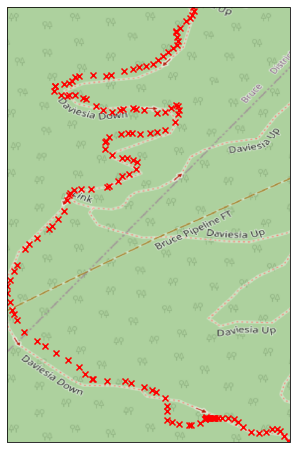

In [6]:
import odmax
# settings
video_file = "../examples/GOPR0011_1599383304667.mp4"

Video = odmax.Video(video_file)
Video.fps

# Let's have a quick look at the GPS track with the beautiful plotting function for the GPS track. If you have GPS data it'll be plotted

Video.plot_gps(
    geographical=True,
    tiles="OSM",
    zoom_level=18,
    plot_kwargs={"color": "r", "marker": "x"}
)



Finally we are at the point where we can let `odmax` extract stills, reproject them, and upload them into the defined task. Let's first open a video and then define some settings we want to use. We want to extract stills from `t_start = 23` until `t_end = 76`. We choose this part because it is a part of video where some turns are taken and therefore lots of imagery is captured from different angles. With `odmax` functionalities we make a list of frames to process. 

In [ ]:
t_start = 23
t_end = 76
# get the start and end frame
start_frame = odmax.io.get_frame_number(Video.cap, t_start)
end_frame = odmax.io.get_frame_number(Video.cap, t_end)

frames = list(range(start_frame, end_frame, 5))
print(frames)


Now we need to do several things in a loop. Per frame we will:
* extract the frame using `Video.get_frame`. Let's skip reprojection for now, but you could add with `reprojection=True`
* encode the images into a ByteIO stream (we do not write any intermediate result to disk!). This stream can be    directly uploaded.
* make a list of images with file names ready for uploading. This follows the ODM API, see https://docs.webodm.org.
* Upload these images to the open WebODM task. 

To make this easier, we make a small helper function for the encoding. We also check if there is already a thumbnail for the stills, if that is the case we don't bother re-uploading it. We use `tqdm` to track progress. It will take a while!

In [ ]:
import cv2
import io
from tqdm.notebook import tqdm


work = tqdm(frames, leave=True)
for f in work:
    # read the frame
    Frame = Video.get_frame(f)
    # convert into bytestream
    bytestream = Frame.to_bytes()
    # prepare fields for upload 
    filename = "still_{:04d}.jpg".format(f)
    fields = {
        "images": (
            filename,
            bytestream,
            'images/jpg'
        )
    } 
    res = odm_requests.get_thumbnail(url, token, project_id, task_id, filename=filename)
    if res.status_code == 200:
        work.set_description(f"File {filename} already exists on ODM task, skipping...")
    else:
        work.set_description(f"Uploading {filename}")
        # add field to uploads of tasks. In the post below, the actual uploading of one face of one frame is occurring
        res = odm_requests.post_upload(url, token, project_id, task_id, fields)  

    
    


It is time to have a look at your current task within the WebODM environment. You will get the link to the appropriate task below. Click on it to display it in a separate window. You may have to login first, and then click on the link below again once logged in to get the right task. Return after inspection to do the final parts.

In [ ]:
end_point = f"{url}/dashboard/?project_task_open={project_id}&project_task_expanded={task_id}"
print(end_point)

We can now commit the task so that it'll process and run

In [ ]:
res = odm_requests.post_commit(url, token, project_id, task_id).json()
print(res)

In [ ]:
import time
running_progress = 0.
print("The status bar below shows how far the processing is. When this is reaching 100% go back to your ODM server and check the results. Dependent on the resources, this may take a long time. You can also still got to:")
print(end_point)
print("if you like to see the WebODM web-interface")
with tqdm(total=100) as pbar:
    while running_progress < 1.:
        res = odm_requests.get_task(url, token, project_id, task_id)
        status = res.json()
        running_progress = status["running_progress"]
        time.sleep(1)
        pbar.n = running_progress*100
        pbar.refresh()
    